In [2]:

import warnings 
warnings.filterwarnings('ignore')

import tensorflow as tf 
from tensorflow import keras 

import cv2 

import numpy as np 
import pandas as pd 
import seaborn as sns

import matplotlib.pyplot as plt 


2024-07-25 16:04:46.171965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 16:04:46.172117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 16:04:46.472925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
'''
PROJECT - TRAJECTORY PREDICTION OF AUTOMOBILES / PREDESTRIANS FOR SELF DRVING CARS 

PIPELINE - 
1. Took dataset of windshield view with Bounding Boxes , did preprocessing (extracted the most prominent BB) and used Transfer LEarning
(Xception skip connections) to 
re-train the model a bit to learn the features in new dataset and predicted Centre( exact location) of the predestrain
/vehicle 

2. Then , tokk the last feature map fromCNN ( contain imp features ) and passed it to the RNN ( after reshaping input)
such that ( timesteps = Spatial Dim , features= no of new channels formed  in Final feature map )

3. trained my LSTM network for One-step forecasting( New pos of Pedestrian )

Do this work now 

4. Now , wok on  tuning both the models m fianl results , do mUlti-Step Forecasting to predict future 10 steps 

5. And draw BB arounf these furur 10 timesteps ,  represing them and integrate it toa  video frame . 

6. 
First Approah - 
How I did Multi Step Forecasting
- I took an image , did One-Step Forecasting and found 1 Future(x,y) coordinate. 
Then , made a rectangle in the original Image ( using previously predicted x,y) Now , passed this new 
Edited Image in the Same LSTM network and then found another Prediction 
Inconsistent Results with No variations , ( and error propogation in futurre time steps )



87. USe Time-Distriburted Layer to process all 10 images first and then ONLY pass to LSTM network 
AND ONLY USE FUNCTIONAL API FROM NOW ( gives more independence and gives better results)
// by cocatenating two diff data types input for better prediction .



# ANd i used incrementakl learning to re-trian the model on the alrge dataset 
# and then ppcikles and saved the model 

We can Improve the results By drawing Bounding boxs ( just i like Dew above in the training Images dataset )
'''

'\nPROJECT - TRAJECTORY PREDICTION OF AUTOMOBILES / PREDESTRIANS FOR SELF DRVING CARS \n\nPIPELINE - \n1. Took dataset of windshield view with Bounding Boxes , did preprocessing (extracted the most prominent BB) and used Transfer LEarning\n(Xception skip connections) to \nre-train the model a bit to learn the features in new dataset and predicted Centre( exact location) of the predestrain\n/vehicle \n\n2. Then , tokk the last feature map fromCNN ( contain imp features ) and passed it to the RNN ( after reshaping input)\nsuch that ( timesteps = Spatial Dim , features= no of new channels formed  in Final feature map )\n\n3. trained my LSTM network for One-step forecasting( New pos of Pedestrian )\n\nDo this work now \n\n4. Now , wok on  tuning both the models m fianl results , do mUlti-Step Forecasting to predict future 10 steps \n\n5. And draw BB arounf these furur 10 timesteps ,  represing them and integrate it toa  video frame . \n\n6. \nFirst Approah - \nHow I did Multi Step Forecast

In [4]:
data = pd.read_csv("/kaggle/input/self-driving-cars/labels_train.csv")

# Feature extraction( to find Area of Bounding Box )
data['area'] = abs( data['xmin']-data['xmax'])* abs( data['ymin']-data['ymax'])

In [5]:
# filter the image daatset( with BB area>=2000 -> prominet BB - only took these BB )
data = data[ (data['area']>=2000) & (data['xmin']>=50) & (data['xmin']<=200) & (data['xmax']<=350) & (data['xmax']>=200) ]
data.head()

,frame,xmin,xmax,ymin,ymax,class_id,area
327,1478019978686299906.jpg,139,274,124,170,1,6210
337,1478019983689760521.jpg,193,335,122,188,2,9372
1074,1478020241197041221.jpg,109,225,105,168,1,7308
1082,1478020241689891151.jpg,152,246,107,170,1,5922
1092,1478020242196911641.jpg,188,265,107,169,1,4774


In [6]:
''' Define the center of B Box to find exact location '''
pos = data.copy()

pos['x_pos'] = (pos['xmin'] + pos['xmax'])//2 
pos['y_pos'] = (pos['ymin'] + pos['ymax'])//2 

pos.drop(['xmin' , 'xmax' , 'ymin' , 'ymax' , 'class_id', 'area'] , axis =1  , inplace = True )

In [7]:
pos.head()

,frame,x_pos,y_pos
327,1478019978686299906.jpg,206,147
337,1478019983689760521.jpg,264,155
1074,1478020241197041221.jpg,167,136
1082,1478020241689891151.jpg,199,138
1092,1478020242196911641.jpg,226,138


In [8]:
# img = cv2.imread( "/kaggle/input/self-driving-cars/images/" + pos.iloc[0]['frame'])
# # img = cv2.cvtColor( img , cv2.COLOR_BGR2RGB)
# plt.imshow( img  , cmap = 'gray')
# cv2.rectangle( img , ( pos.iloc[0]['xmin'] ,pos.iloc[0]['ymin']) , ( pos.iloc[0]['xmax'] ,pos.iloc[0]['ymax']) , (0,255,0) , 2)
# plt.imshow( img  , cmap = 'gray')

In [9]:
# feature scaling - for bettee and fast convergence

from sklearn.preprocessing import StandardScaler 
scale = StandardScaler( )
pos[ ['x_pos' , 'y_pos']]  = scale.fit_transform( pos[['x_pos' , 'y_pos' ]] )

# pos.drop( ['x_pos' , 'y_pos'] , axis =1 , inplace =True  )

# pos = pd.concat( [ pos , pos_1 ] , axis =1 )




In [10]:
pos.head()

,frame,x_pos,y_pos
327,1478019978686299906.jpg,-0.028400,-1.293080
337,1478019983689760521.jpg,1.811987,-0.863297
1074,1478020241197041221.jpg,-1.265901,-1.884031
1082,1478020241689891151.jpg,-0.250515,-1.776586
1092,1478020242196911641.jpg,0.606217,-1.776586


In [11]:
''' Take the features of the image , and pass it to LSTM network and use the 
sequential Box Coord as the label '''

from keras.applications  import MobileNetV2

base_model =  MobileNetV2( include_top = False ,weights= 'imagenet', input_shape = (128 ,128 , 3 )) 


# for layer in base_model.layers :
#     layer.trainable = False 
    
Cnn = keras.models.Sequential([
   base_model,
    keras.layers.GlobalAveragePooling2D() ,
    #keras.layers.Flatten() ,
    keras.layers.Dense( 100 ,activation = 'relu') , 
    keras.layers.Dropout(0.1), 
    keras.layers.Dense(50 , activation = 'relu'), 
    keras.layers.Dropout(0.1 ) ,
    keras.layers.Dense(2)
])



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
Cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [13]:
'''  Travel in the Dir of images and store first 10 images for training
and their labels PArallely '''

root = "/kaggle/input/self-driving-cars/images/"

Img_data = []
#Original_img = []
Labels = []

# no of images you want the tranfer learning to work  on 

for i in range( pos.shape[0]  ):
    img = cv2.imread(root +pos.iloc[i]['frame'])
    x_ = pos['x_pos'].iloc[i]
    y_ = pos['y_pos'].iloc[i]
    #Original_img.append(img)
    '''Draw a small BB during training to better capture features '''
    cv2.rectangle( img , (int(x_) ,int(y_)) , ( int(x_+ 30) ,int(y_ + 30 ) ) , (0 ,255, 255)  , 3 )
    
    
    img= img/255
    img = cv2.resize( img , (128,128 ))
    
    Img_data.append([img] )
    Labels.append([x_ , y_] )
    

In [14]:
Img_data = np.array(Img_data)
Labels = np.array( Labels )
# Original_img = np.array( Original_img )

In [15]:
# to elimibnate the 2nd dim of tensor ( batches , h , w , channesl)
Img_data = Img_data.reshape( Img_data.shape[0] ,Img_data.shape[2] , Img_data.shape[3] , Img_data.shape[4])

In [16]:
# training byfreezing bottom layers 

for layer in base_model.layers :
    layer.trainable = False 
    
my_adam = keras.optimizers.Adam(learning_rate=0.01)

Cnn.compile( loss = 'mse' , optimizer = my_adam , metrics=['mae'])

# all these computed values - loss , train_loss , val_loss , val_acc are stored in history (pd.Dataframe) with these 4 values in its each epoch column

history = Cnn.fit( Img_data[:1200] , Labels[:1200], batch_size = 32 , epochs = 10 , validation_split  = 0.2  )

# it return a list of val_acc , so select maximum(recent of this)
val_acc = max(history.history['val_mae'] )

# -retrianing after passing validation error threshold
if val_acc>=0.8 :
    
    for layer in base_model.layers :
        layer.trainable = True 

     # retarin after un freezing the CNN weights 
    
    adam_new = keras.optimizers.Adam(learning_rate=0.0005 )
    Cnn.compile( loss = 'mse' , optimizer = adam_new , metrics=['mae'])
    Cnn.fit( Img_data[:1200] , Labels[:1200] , batch_size = 32 , epochs =  10   )


Epoch 1/10
 8/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 27.8267 - mae: 3.4246

I0000 00:00:1721923575.411336     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721923575.448375     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 14.3528 - mae: 2.2040

W0000 00:00:1721923579.036676     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - loss: 13.7905 - mae: 2.1469 - val_loss: 0.8227 - val_mae: 0.7492
Epoch 2/10
11/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6804 - mae: 0.6289

W0000 00:00:1721923583.140957     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6710 - mae: 0.6197 - val_loss: 1.0152 - val_mae: 0.7665
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5671 - mae: 0.5625 - val_loss: 0.9173 - val_mae: 0.7243
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4716 - mae: 0.5164 - val_loss: 0.8795 - val_mae: 0.7507
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4008 - mae: 0.4654 - val_loss: 0.9978 - val_mae: 0.7734
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3835 - mae: 0.4519 - val_loss: 1.0435 - val_mae: 0.7587
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3093 - mae: 0.4029 - val_loss: 0.9759 - val_mae: 0.7552
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3319 - mae: 0.4062 - val_loss: 0.9584 - val_mae: 0.7407
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2888 - mae: 0.3854 - val_loss: 1.0240 - val_mae: 0.7658
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2631 - mae: 0

In [17]:
base_model_ = Cnn.layers[0]



In [18]:
feature_map = base_model.predict(Img_data[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [34]:
batch , h , w , ch = feature_map.shape

batch , h , w , ch


(1, 4, 4, 1280)

In [20]:
# Reshape Img Data and labels with  taking every  10 images and every 10 labels and then shift by 1 stride and make new array 


class TimeDistributedBaseModel(keras.layers.Layer):
    def __init__(self, Base_model):
        super(TimeDistributedBaseModel, self).__init__()
        self.base_model = Base_model

        # the time sistributed layer inherited properties from keras.LAyers of neuron and send this info forward 
        # and thne I overrided the class() method of keras.laueyrs that automatically reshaped the input where batch_and times teps 
        # were combiend to produce a single output (h,w, channels)
    def call(self, inputs):
        shape = tf.shape(inputs)
        batch_size, time_steps = shape[0], shape[1]
        
        # -1 for auto ati cresizing of that dim 
        inputs = tf.reshape(inputs, ( batch_size*time_steps , shape[2], shape[3], shape[4]))
        # pass this pre-prcoessed line of 10 nip images in pre-trained CNN model 
        # to extract feature map of img . 
        
        outputs = self.base_model(inputs)
        
        # it flattende the image(into) - batch size*tsteps , h x w x channels
        
        # final output (spatial and depth dim combiend with time steps given )
        outputs = tf.reshape(outputs, (batch_size, time_steps, -1))
        return outputs
    
    # to set class variable and pickling 
    def get_config(self):
        config = super().get_config()
        config.update({
            "base_model": self.base_model,
        })
        return config

    @classmethod
    def from_config(cls, config):
        base_model = config.pop("base_model")
        return cls(base_model, **config)



In [21]:

# Stacked LSTM srchitecture augemented with feature map from CNN (Xception) model 

def Lstm_net():
    
    # Input layers(ALL  20 images in 1 go)
    inp_img = keras.layers.Input(shape=(10, 128, 128, 3))
    
    # labels (corrspondin those 20 imaes , ALL  labels of 10 (x,y ) coord. passed at 1 go  )
    inp_lab = keras.layers.Input(shape=(10, 2))

#input 
    # Apply base model with TimeDistributedBaseModel
    X = TimeDistributedBaseModel(base_model_)(inp_img)

    
    h, w, ch = base_model_.output_shape[1], base_model_.output_shape[2], base_model_.output_shape[3]
    
    # 10 timesteps at 1 go input , with flattened feature maps 
    X = keras.layers.Reshape((10, h * w * ch))(X)

    # Concatenate flattened image features alongwith its correpsonding labels
    X = keras.layers.Concatenate(axis=-1)([X, inp_lab])

    # Stacked STM 
    X = keras.layers.LSTM(units=128, return_sequences=True)(X)
    # dropout regularization 
    X = keras.layers.Dropout(0.5)(X)
    X = keras.layers.BatchNormalization()(X) # always pass prev computed output (as n input to new layer )
    
    X = keras.layers.LSTM(units=64, return_sequences=True)(X)
    X = keras.layers.Dropout(0.5)(X)
    X = keras.layers.BatchNormalization()(X)
    
    X = keras.layers.LSTM(units=32, return_sequences=True)(X)
    X = keras.layers.LSTM(units=16)(X)

    # Output layer(10 timesteps = 10 coordinates = 20 (x,y))
    out = keras.layers.Dense(20)(X)  
    out = keras.layers.Reshape((10, 2))(out)

    # Define the model
    Lstm_net = keras.models.Model(inputs=[inp_img, inp_lab], outputs=out)

    # Compile the model
    Lstm_net.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    return Lstm_net

#Initialize the model 
Lstm_Net = Lstm_net()

In [22]:
Img_data = Img_data.reshape( pos.shape[0] , 128 ,128  , 3 )
Img_data.shape

(3772, 128, 128, 3)

In [23]:
X  = [] 
y = []

# take 20 timesteps image 
# future 10 timesteps labels 
# (initial 20 timestpa are always lost in multistep multivariate forecasting)

sz = 2600

for i in range( sz ) :
    X.append( [Img_data[i:i+10 ]] )
    y.append( Labels[i+10])
    
X = np.array(X)
y = np.array(y)



In [24]:
X.shape

(2600, 1, 10, 128, 128, 3)

In [25]:
X  =X.reshape( sz ,10 , 128 ,128  , 3)
X.shape

(2600, 10, 128, 128, 3)

In [26]:
y = np.expand_dims(y, axis=1)  # Adds a new axis at index 1
y = np.tile(y, (1, 10, 1))
y.shape


(2600, 10, 2)

In [27]:
# pd.DataFrame( history.history).plot()
# plt.show()

Lstm_Net.fit( [X,y] ,  y , epochs = 200 ) 

Epoch 1/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - loss: 0.8901 - mae: 0.7401
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - loss: 0.5928 - mae: 0.5842
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - loss: 0.4733 - mae: 0.5050
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 0.4558 - mae: 0.4878
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 0.4286 - mae: 0.4667
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 0.4162 - mae: 0.4658
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 0.4011 - mae: 0.4497
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 0.3899 - mae: 0.4423
Epoch 9/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 0.3975 - mae: 0.4471
Epoch 10/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - loss: 0.3644 - mae: 0.4246
Epoch 11/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 0.3747 - mae: 0.4290
Epoch 12/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 0.3425 - mae: 0.4056
E

In [28]:
def preprocess( img) :
    
    img= img/255
    img = cv2.resize(img ,(128,128) )
    img = img.reshape((1, img.shape[0] , img.shape[1] , img.shape[2] ))
    return img 


In [29]:


Test_img = Img_data[10:20].reshape( 1 , 10, 128, 128, 3)
Test_img.shape

Test_label = Labels[10:20 ].reshape( 1 ,10 ,2 )
Test_label.shape

# Make predictions
# predictions = Lstm_Net.predict([dummy, label ])

# for predictiom , give ONLY the iamges 

# Test LAbel is actually not a label( its the current 10 coordinate of the vehicle )
predictions = Lstm_Net.predict([Test_img, Test_label ])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [30]:
predictions = predictions.reshape( 10 , 2 )
ans = scale.inverse_transform(predictions)

In [31]:
# we are predicting multistep time forecasting for 21st img 
# suince in above prediction , we took 20 prev timestep images 

img = cv2.imread(root +pos['frame'].iloc[21 ])

img1 = img 

for i in range( ans.shape[0]) :
    x = int(ans[i][0])
    y = int(ans[i][0])
    cv2.line(img , ( x , y ) , (x+30 , y+30)  ,(0,0 ,255) , 2  ) # opencv uses BGR format , plot uses RGB format 
    cv2.rectangle(img1 , ( x , y ) , (x+50 , y+50)  ,( 0 ,255 ,255 ) , 1   )



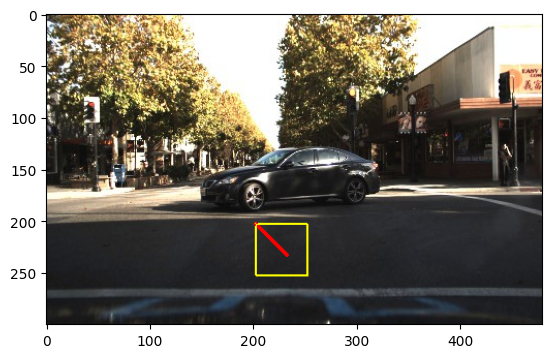

In [32]:
img = cv2.cvtColor( img , cv2.COLOR_BGR2RGB)
plt.imshow( img)
plt.show()




In [35]:
# to save models , use inbuilt keras function (.save)

Lstm_Net.save("lstm_net.h5")
base_model_.save( "cnn_layer.h5")